In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19, MobileNetV2
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import random
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_dir = '/content/drive/MyDrive/pr_dataset/train'
val_dir = '/content/drive/MyDrive/pr_dataset/train'
test_dir = '/content/drive/MyDrive/pr_dataset/test'

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=IMG_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    subset='training',
                                                    class_mode='categorical')


val_generator = train_datagen.flow_from_directory(train_dir,
                                                target_size=IMG_SIZE,
                                                batch_size=BATCH_SIZE,
                                                subset='validation',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=IMG_SIZE,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical')

Found 2110 images belonging to 2 classes.
Found 527 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [4]:
ben_dir='/content/drive/MyDrive/pr_dataset/train/benign'
malig_dir='/content/drive/MyDrive/pr_dataset/train/malignant'

ben = random.sample(os.listdir(ben_dir),5)
malig = random.sample(os.listdir(malig_dir),5)


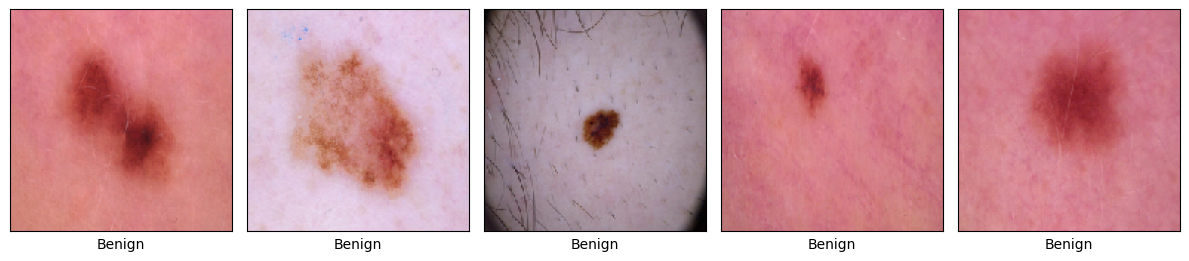

In [5]:
plt.figure(figsize=(12,7))
for i,img in enumerate(ben):
    path = os.path.join(ben_dir,img)
    img = load_img(path, target_size=(150,150))
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.xlabel("Benign")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout();

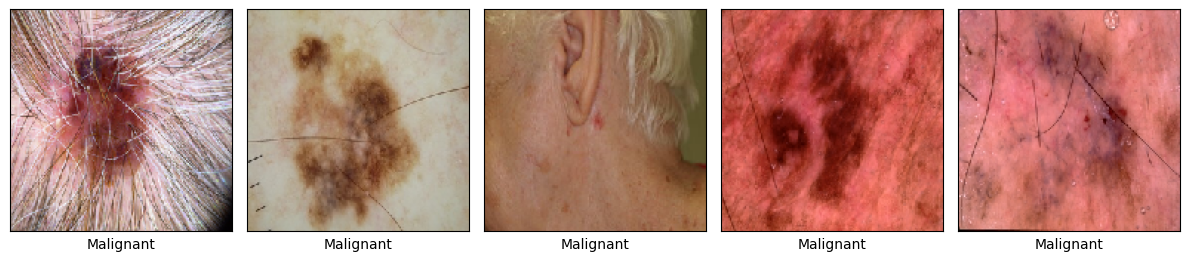

In [6]:
plt.figure(figsize=(12,7))

for i,img in enumerate(malig):
    path = os.path.join(malig_dir,img)
    img = load_img(path, target_size=(150,150))
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.xlabel("Malignant")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout();

In [7]:
# Train the teacher model
inputs = Input(shape=IMG_SIZE + (3,))
base_model = VGG19(weights='imagenet',include_top=False, input_tensor=inputs)

#Add custom layers to it
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
predictions = Dense(2, activation='sigmoid')(x)

teacher_model = Model(inputs=inputs, outputs=predictions)

#select layers for trainning
for layer in teacher_model.layers:
    layer.trainable = True

#printing model summary
print(teacher_model.summary())

80134624/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [8]:
#compile teacher model
teacher_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history=teacher_model.fit(train_generator,
                  epochs=15,
                  validation_data=val_generator,
                  steps_per_epoch=train_generator.samples // BATCH_SIZE,
                  callbacks=[tf.keras.callbacks.EarlyStopping(patience=4)],
                  )


teacher_model.save_weights('teacher_model_weights.h5')

Epoch 1/15
65/65 [==============================] - 497s 7s/step - loss: 0.7805 - accuracy: 0.5284 - val_loss: 0.6891 - val_accuracy: 0.5465
Epoch 2/15
65/65 [==============================] - 54s 827ms/step - loss: 0.6928 - accuracy: 0.5332 - val_loss: 0.6993 - val_accuracy: 0.5465
Epoch 3/15
65/65 [==============================] - 54s 836ms/step - loss: 0.6912 - accuracy: 0.5448 - val_loss: 0.6895 - val_accuracy: 0.5465
Epoch 4/15
65/65 [==============================] - 52s 792ms/step - loss: 0.6900 - accuracy: 0.5443 - val_loss: 0.6888 - val_accuracy: 0.5465
Epoch 5/15
65/65 [==============================] - 53s 817ms/step - loss: 0.6924 - accuracy: 0.5390 - val_loss: 0.6898 - val_accuracy: 0.5465
Epoch 6/15
65/65 [==============================] - 53s 820ms/step - loss: 0.6893 - accuracy: 0.5452 - val_loss: 0.6889 - val_accuracy: 0.5465
Epoch 7/15
65/65 [==============================] - 53s 811ms/step - loss: 0.6885 - accuracy: 0.5486 - val_loss: 0.6888 - val_accuracy: 0.5465
E

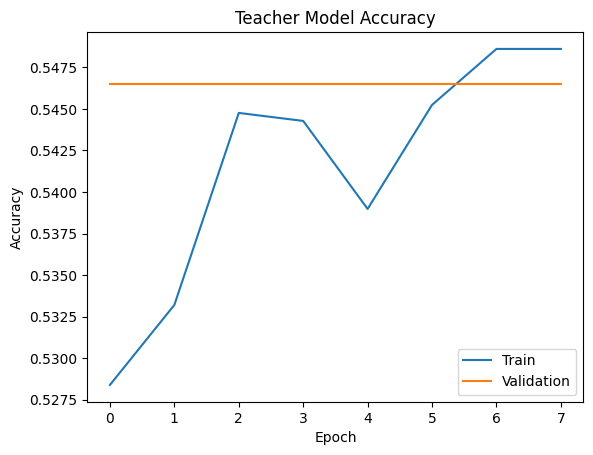

In [9]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Teacher Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

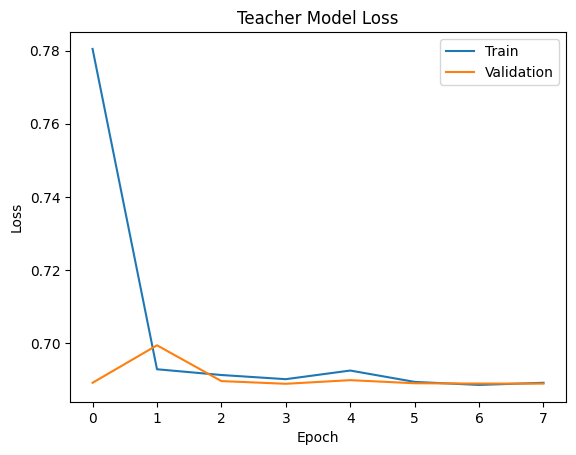

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Teacher Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [11]:
# Generate soft labels
temperature = 5

soft_labels = teacher_model.predict(train_generator)
soft_labels = tf.nn.softmax(soft_labels / temperature)

66/66 [==============================] - 36s 544ms/step


In [12]:
# Define the student model
inputs = Input(shape=IMG_SIZE + (3,))
base_model = VGG19(include_top=False, input_tensor=inputs)

#Add custom layers to it
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
predictions = Dense(2, activation='sigmoid')(x)

student_model = Model(inputs=inputs, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = True

print(student_model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [13]:
#compile student model
student_model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'],loss_weights=[1., 0.5])
#BATCH_SIZE = 64
history = student_model.fit(train_generator,
                            epochs=35,
                            validation_data=val_generator,
                            steps_per_epoch=train_generator.samples // BATCH_SIZE,
                            callbacks=[tf.keras.callbacks.EarlyStopping(patience=4)],
                            class_weight={0: 1, 1: 2},
                            )


Epoch 1/35
65/65 [==============================] - 58s 802ms/step - loss: 0.9063 - accuracy: 0.5943 - val_loss: 0.5284 - val_accuracy: 0.8027
Epoch 2/35
65/65 [==============================] - 54s 831ms/step - loss: 0.6470 - accuracy: 0.8070 - val_loss: 0.4392 - val_accuracy: 0.7875
Epoch 3/35
65/65 [==============================] - 54s 827ms/step - loss: 0.5667 - accuracy: 0.8099 - val_loss: 0.4395 - val_accuracy: 0.8216
Epoch 4/35
65/65 [==============================] - 53s 820ms/step - loss: 0.5242 - accuracy: 0.8162 - val_loss: 0.4179 - val_accuracy: 0.8254
Epoch 5/35
65/65 [==============================] - 52s 791ms/step - loss: 0.4724 - accuracy: 0.8268 - val_loss: 0.4153 - val_accuracy: 0.8178
Epoch 6/35
65/65 [==============================] - 54s 824ms/step - loss: 0.4621 - accuracy: 0.8277 - val_loss: 0.3972 - val_accuracy: 0.8216
Epoch 7/35
65/65 [==============================] - 53s 815ms/step - loss: 0.4605 - accuracy: 0.8306 - val_loss: 0.3801 - val_accuracy: 0.8254

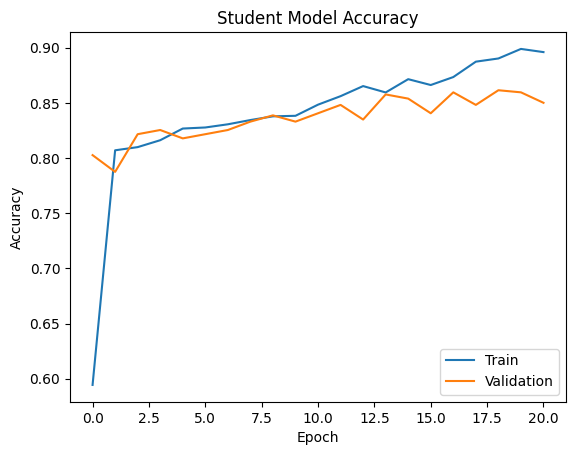

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Student Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

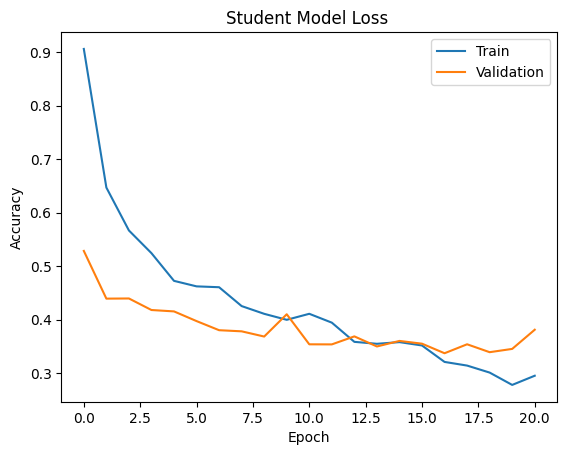

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Student Model Loss ')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [16]:
# Evaluate the student model
test_loss, test_acc = student_model.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

21/21 [==============================] - 201s 10s/step - loss: 0.3242 - accuracy: 0.8576
Test loss: 0.3242303133010864
Test accuracy: 0.8575757741928101


Found 660 images belonging to 2 classes.
21/21 [==============================] - 3s 158ms/step


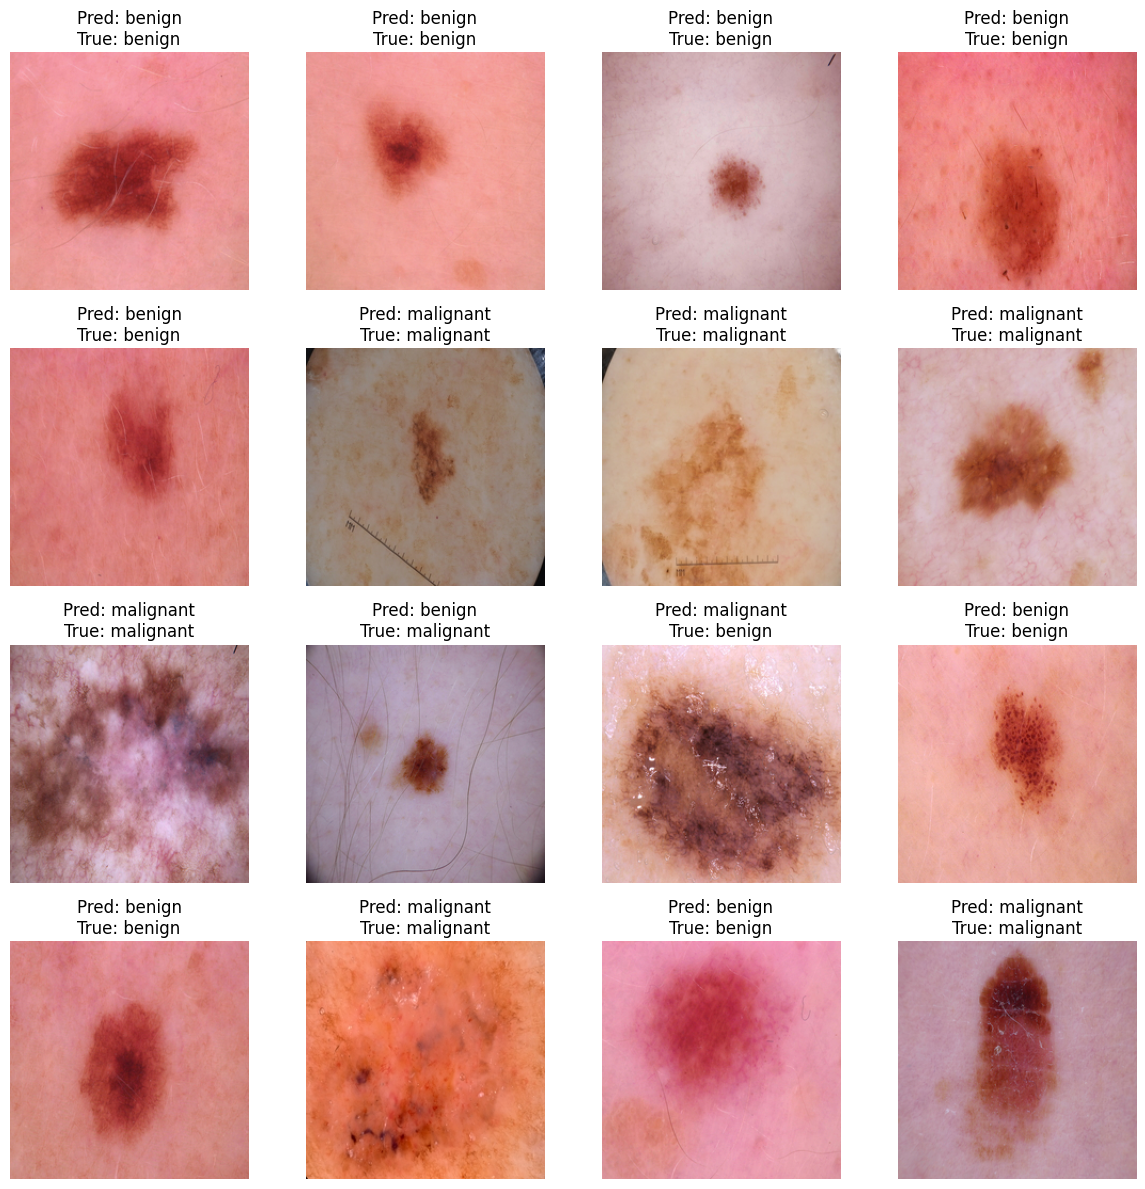

In [17]:
# Prepare the dataset for confusion metrix and evaluation
eva_dir = '/content/drive/MyDrive/pr_dataset/test'

IMG_SIZE = (224, 224)
BATCH_SIZE = 720



eva_datagen = ImageDataGenerator(rescale=1./255)
eva_generator = test_datagen.flow_from_directory(eva_dir,
                                                  target_size=IMG_SIZE,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical')
# Get the next batch of images from the test generator
x_test, y_test = next(eva_generator)

# Predict the classes of the testing data
y_pred = student_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
label_dict = {0: 'benign', 1: 'malignant'}

# Plot the images along with their predicted and actual labels
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12,12))

for i, ax in enumerate(axes.flat):
  ax.imshow(x_test[i])
  pred_label = label_dict[y_pred_classes[i]]
  true_label = label_dict[y_true_classes[i]]
  ax.set_title("Pred: {}\nTrue: {}".format(pred_label, true_label))
  ax.axis('off')
plt.tight_layout()
plt.show()

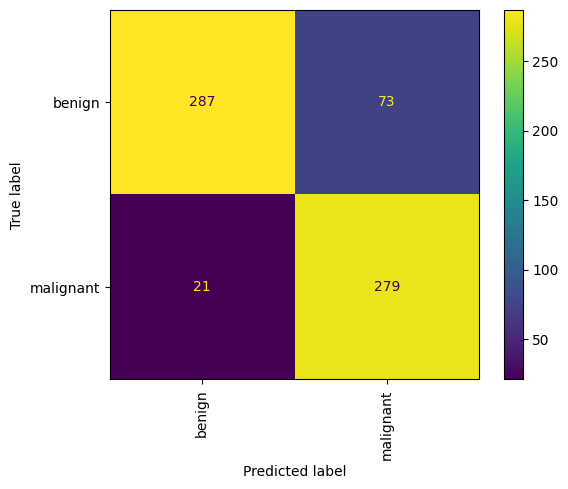

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,  ConfusionMatrixDisplay

#printing confusion matrix for  1 Batch
cm1 = confusion_matrix(y_true_classes, y_pred_classes)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1)
disp1.plot()
tick_marks = np.arange(len(test_generator.class_indices))
plt.xticks(tick_marks, test_generator.class_indices, rotation=90)
plt.yticks(tick_marks, test_generator.class_indices)
plt.show()